<a href="https://colab.research.google.com/github/schnappv/ISYE6644/blob/main/ISYE_6644_Mini_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Spread of a Flu Simulated through Python

*Michael Barnhart, Valerie Schnapp, and Jonathon Yang*

-----

Consider a classroom of 21 elementary school kids.  20 of the kids are healthy (and susceptible to flu) on Day 1.  Tommy (the 21st kid) walks in with the flu and starts interacting with his potential victims.  To keep things simple, let’s suppose that Tommy comes to school every day (whetheror not he’s sick) and will be infectious for 3 days.  Thus, there are 3 chances for Tommy to infect the other kids — Days 1, 2, and 3.  Suppose that the probabilitythat he infects any individual susceptible kid on any of the three days is p= 0.02; and suppose that all kids and days are independent (so that you have i.i.d. Bern(p) trials).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from IPython.display import HTML, display
from scipy import stats
from scipy.integrate import odeint

In [ ]:
# initiate a progress bar for running the simulation
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
    
out = display(progress(0, 100), display_id=True)

### SIR Model 

In [2]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    
    return dSdt, dIdt, dRdt

In [17]:
t = np.linspace(0, 30, 30) # 30 days ~ 1 month
n = 21 # total number of students
I0 = 1 # infected at time 0
R0 = 0 # recovered at time 0
S0 = 20 # susceptible at time 0
beta = 0.02 # susceptibility rate
gamma = 1/3 # mean recovery rate

y0 = [S0, I0, R0]

# Integrate the SIR equations over the time grid t
ret = odeint(deriv, y0, t, args=(n, beta, gamma))
S, I, R = ret.T

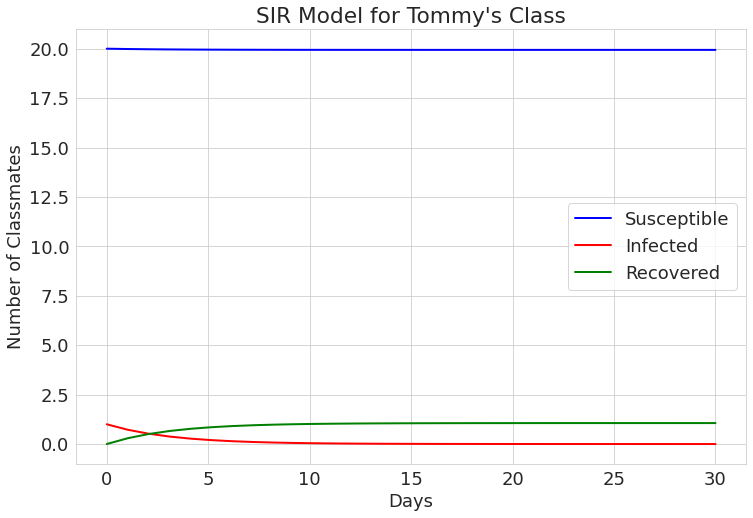

In [27]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
plt.rcParams.update({'font.size':18})
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
plt.plot(t, S, 'b', lw=2, label='Susceptible')
plt.plot(t, I, 'r', lw=2, label='Infected')
plt.plot(t, R, 'g', lw=2, label='Recovered')
plt.title("SIR Model for Tommy's Class")
plt.xlabel('Days')
plt.ylabel('Number of Classmates')
plt.legend()
plt.show()

Based on this differential equation model, Tommy will not infect and students and the flu will leave his class when he is recovered after 3 days.

Let's explore this more as a simulation now.

### (a) What is the distribution of the number of kids that Tommy infects on Day 1

Since there are 20 students that could be infected my Tommy, there are 20 i.i.d `Bernoulli(p=0.02)` trials. This means that the distribution of the number of kids that Tommy infects on Day 1 is `X~Binomial(n=20, p=0.02)`. Now, we can simulate this distribution over `N=10000` trials. 

In [ ]:
n = 21 # total number of students
I0 = 1 # infected at time 0
R0 = 0 # recovered at time 0
S0 = 20 # susceptible at time 0
p = 0.02 # susceptibility rate
N = 10000 # number of simulation trials

In [ ]:
# set a random seed for reproducability 
np.random.seed(42)
for j in range(N):
  infected_by_tommy_on_day_one = stats.binom.rvs(n-I0, p, size=N)
  out.update(progress(j, N))

In [ ]:
# display a summary of the number of students infected by Tommy day 1 over N trials
pd.DataFrame(infected_by_tommy_on_day_one).describe().T

,count,mean,std,min,25%,50%,75%,max
0,10000.0,0.3975,0.620268,0.0,0.0,0.0,1.0,4.0


Text(0, 0.5, 'Simulation Trials')

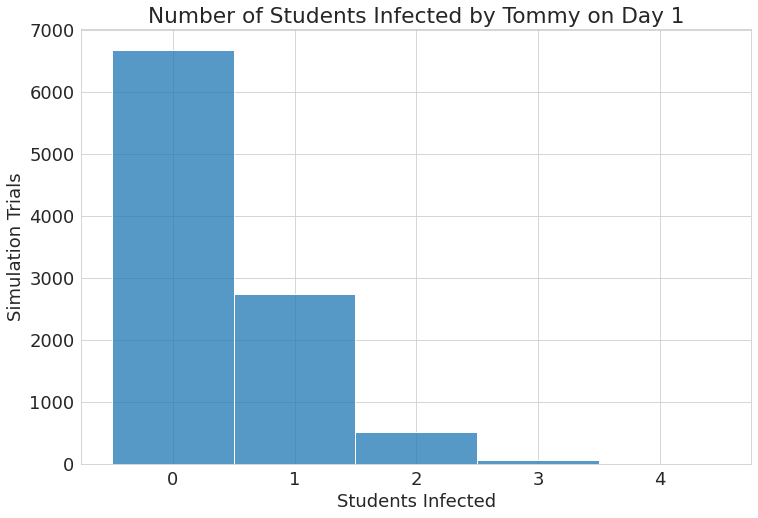

In [ ]:
plt.rcParams.update({'font.size':18})
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
plt.title("Number of Students Infected by Tommy on Day 1")
sns.histplot(infected_by_tommy_on_day_one, discrete=True, kde=False,
             bins=range(5))
plt.xlabel("Students Infected")
plt.ylabel("Simulation Trials")
plt.show()

The summary show’s a right skewed distribution (i.e. the mode is less than the median is less than the mean) that heavily favors the number of students to be infected by Tommy on day one to be only 0 students. 


### (b) What is the expected number of kids that Tommy infects on Day 1?

`E[X] = n*p` for a Binomial distribution (i.e. `n` Bernoulli trials). `E[X] = 20 susceptible * 0.02 = 0.4`. 

In [ ]:
I1 = 1 # Students infected on day 1
R1 = 0 # Students recovered on day 1
S1 = 21 - I1 # Students susceptible on day 1

Ex1 = S1 * (I1 * p)
print("At day one, E[x] = ", Ex1)

At day one, E[x] =  0.4


Since you can’t have a fraction of a person, we are going to take the ceiling of this and expect that one student to be infected on Day 1.

### (c) What  is  the  expected  number  of  kids  that  are  infected  by  Day  2  (you  can count Tommy if you want)?


`E[X] = n*p`. Since we now have 2 infected people (Tommy plus the person he infected), `n=21-1.4=19.6`. This also means we need to double the probability.

In [ ]:
I2 = 1 + Ex1 # Students infected on day 2
R2 = 0 # Students recovered on day 2
S2 = 21 - I2 # Students susceptible on day 2

Ex2 = S2 * (I2 * p)
print("At day 2, E[x] = ", Ex2)

At day 2, E[x] =  0.5488


Since you can’t have a fraction of a person, we are going to take the ceiling of this and expect that one student to be infected on Day 2. We now expect there to be 3 people infected by Day 3.

### (d) Simulate the number of kids that are infected on Days 1,2,. . . .  Do this many times.  What are the (estimated) expected numbers of kids that are infected by Day i = 1, 2, . . .?  Produce a histogram detailing how long the “epidemic” will last.

In [ ]:
# total number of students
n = 21
# infected at time 0
I0 = 1
# recovered at time 0
R0 = 0
# susceptible at time 0
S0 = 20

In [ ]:
def simulate_flu(n, p, I0, gamma):
  """
  Simulates the flu spread in Tommy's class and determines the number of days
  the flu will last for. Assume the infection lasts for gamma days and 
  you are recovered after (no longer susceptible). Simulation terminates
  when either no more students are infected or no more studets are susceptible.

  Parameters
  --------
  n : int
    The number of students in the class
  
  p : float
    The probability of infecting someone if you are infected
  
  I0 : int
    The number of students initially infected
  
  gamma : int
    The number of days infection lasts for
  
  Returns
  --------
  df : pd.DataFrame
    A dataframe with daily records on students infected, susceptible, and recovered
  """
  t = 0
  infected = np.array([gamma]*I0)
  num_infected = len(infected)
  p_i = p * num_infected
  num_recovered = 0
  num_sus = n - num_infected - num_recovered
  df = pd.DataFrame()
  for t in range(100):
    if np.all(infected <= 0) or num_sus < 1:
      while t < 22: # 22 was determined by running the simulation and finding it to be the maximum number of days
        df = df.append(pd.DataFrame({
          "Day": t+1,
          "Students Infected": 0,
          "Students Susceptible": 0,
          "Students Recovered": num_recovered,
          "Probability of Infection": 0
          }, index=[t]), ignore_index=True)
        t += 1
      return df
    df = df.append(pd.DataFrame({
        "Day": t+1,
        "Students Infected": num_infected,
        "Students Susceptible": num_sus,
        "Students Recovered": num_recovered,
        "Probability of Infection": p_i
        }, index=[t]), ignore_index=True)
    day_t_infected = np.random.binomial(num_sus, p_i)
    if day_t_infected != 0:
      infected = np.append(infected, np.ones(day_t_infected) * gamma+1)
    num_infected = len(infected[infected != 0])
    t += 1
    infected -= 1
    num_recovered += len(np.where(infected == 0)[0])
    p_i = p * num_infected
    num_sus = n - num_infected - num_recovered

In [ ]:
# run the simulation without a random seed
np.random.seed(None)
df = simulate_flu(n=21, p=0.02, I0=1, gamma=3)

# display results for one run
df.set_index("Day")

,Students Infected,Students Susceptible,Students Recovered,Probability of Infection
Day,,,,
1,1,20,0,0.02
2,2,19,0,0.04
3,2,19,0,0.04
4,2,18,1,0.04
5,2,17,2,0.04
6,2,17,2,0.04
7,3,16,2,0.06
8,0,0,3,0.00
9,0,0,3,0.00


In [ ]:
days_of_simulation = []
total_df = pd.DataFrame()
N = 10000

# Run the simulation N=10,000 times and display progress with a progress bar
for j in range(N):
    new_df = simulate_flu(n=21, p=0.02, I0=1, gamma=3)
    new_df["simulation_round"] = j
    days_of_simulation.append(len(new_df[new_df["Students Infected"]!=0]))
    total_df = total_df.append(new_df)
    out.update(progress(j, N))

Text(0, 0.5, 'Simulation Trials')

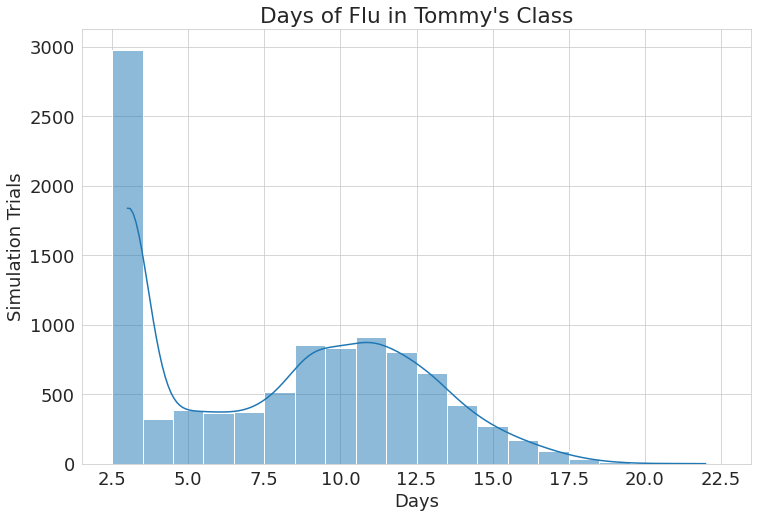

In [ ]:
plt.rcParams.update({'font.size':18})
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
plt.title("Days of Flu in Tommy's Class")
sns.histplot(days_of_simulation, discrete=True, kde=True)
plt.xlabel("Days")
plt.ylabel("Simulation Trials")
plt.show()

In [ ]:
# Display key statistics of the simulation trials
pd.DataFrame(np.array(days_of_simulation)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,10000.0,8.0425,4.229951,3.0,3.0,9.0,11.0,22.0


This shows us that a majority of the runs terminate after 3 days because if Tommy does not infect any students, the infection will be fully gone after three days. For the simulation runs where Tommy does infect a student, then the number of days ranges from 3 to 22. 

In [ ]:
avg_students_infected_per_day = total_df.groupby("Day").mean()[["Students Infected"]][:-1]
avg_students_infected_per_day

,Students Infected
Day,
1,1.0000
2,1.3996
3,1.9214
4,2.3334
5,2.3346
6,3.2328
7,3.7749
8,4.0009
9,4.0617


In [ ]:
total_df.head(20)

,Day,Students Infected,Students Susceptible,Students Recovered,Probability of Infection,simulation_round
0,1,1,20,0,0.02,0
1,2,1,20,0,0.02,0
2,3,1,20,0,0.02,0
3,4,0,0,1,0.00,0
4,5,0,0,1,0.00,0
5,6,0,0,1,0.00,0
6,7,0,0,1,0.00,0
7,8,0,0,1,0.00,0
8,9,0,0,1,0.00,0
9,10,0,0,1,0.00,0


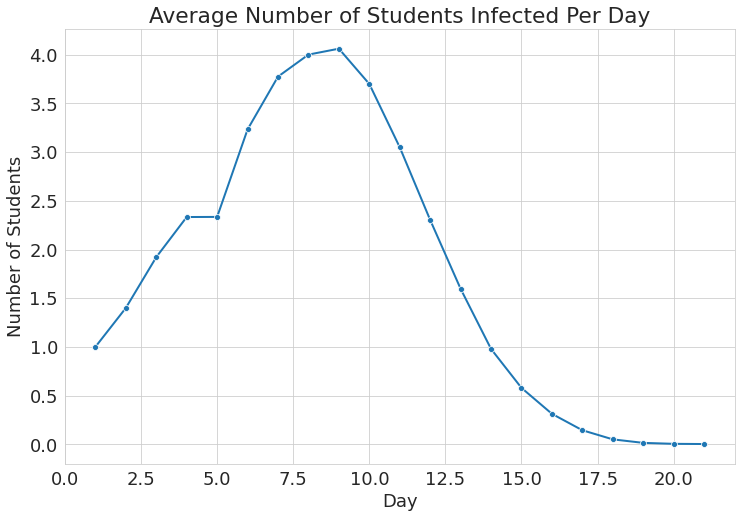

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))

plt.title('Average Number of Students Infected Per Day')
plt.xlabel("Day")
plt.ylabel("Number of Students")
sns.lineplot(x=range(1, 22), y=avg_students_infected_per_day['Students Infected'],
             marker='o', linewidth=2)
plt.show()

In [ ]:
from scipy.stats import geom
p = 0.02
prob = geom.cdf(3, p)
print("The probability that Tommy will infect another student in his 3 days of contagiousness is {}%".format(prob*100))

In [ ]:
pct_of_time_tommy_did_not_spread = len(np.where(np.array(days_of_simulation)==3)[0])/len(days_of_simulation)
print("Out of the 10,000 simulation trials, Tommy did not infect his fellow classmates {}% times.".format(pct_of_time_tommy_did_not_spread * 100))